In [1]:
# imports
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
# local
import wrangle as w
import explore as e
import modeling as m
from env import user,password,host

In [2]:
# 52,441 rows to 51,046, drop less than 3%

In [3]:
def get_zillow(user=user,password=password,host=host):
    # name of cached csv
    filename = 'zillow.csv'
    # if cached data exist
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    # wrangle from sql db if not cached
    else:
        # read sql query into df
        # 261 is single family residential id
        df = pd.read_sql('''select * 
                            from properties_2017 
                            left join predictions_2017 using(parcelid) 
                            where propertylandusetypeid in (261,279)'''
                            , f'mysql+pymysql://{user}:{password}@{host}/zillow')
        # filter to just 2017 transactions
        df = df[df['transactiondate'].str.startswith("2017", na=False)]
        # cache data locally
        df.to_csv(filename, index=False)
    return df

In [4]:
df = get_zillow()
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,17173851,787,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,64712.0,2016.0,17519.0,781.00,NaN,NaN,6.111004e+13,389.0,0.088469,2017-01-03
1,10821119,1702,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,381638.0,2016.0,274127.0,4692.27,NaN,NaN,6.037131e+13,402.0,0.025629,2017-01-03
2,11007640,2412,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,305307.0,2016.0,160505.0,3887.80,NaN,NaN,6.037106e+13,2699.0,0.020360,2017-01-12
3,11457850,3770,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,93146.0,2016.0,54446.0,1246.18,NaN,NaN,6.037276e+13,2229.0,0.054233,2017-01-11
4,12591550,8197,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,482242.0,2016.0,385591.0,6098.62,NaN,NaN,6.037544e+13,3038.0,-0.016170,2017-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52436,12885754,2976765,NaN,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,200214.0,2016.0,106817.0,2629.33,NaN,NaN,6.037403e+13,42657.0,0.515289,2017-06-01
52437,13869000,2977815,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,215695.0,2016.0,80652.0,2607.04,NaN,NaN,6.059002e+13,32297.0,0.009512,2017-05-02
52438,13890509,2977914,NaN,NaN,NaN,4.0,3.0,NaN,NaN,4.0,...,1389962.0,2016.0,1118935.0,14935.72,NaN,NaN,6.059063e+13,28537.0,-0.031048,2017-04-21
52439,17246810,2980979,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,...,403678.0,2016.0,201839.0,4880.90,NaN,NaN,6.111008e+13,8396.0,-0.031665,2017-02-07


In [5]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Dropped some stuff
    
    # Drop column: 'parcelid'
    df = df.drop(columns=['parcelid'])
    
    # Drop column: 'id'
    df = df.drop(columns=['id'])
    
    # Replace missing values with 0 in column: 'airconditioningtypeid'
    df = df.fillna({'airconditioningtypeid': 0})
    
    # Replace all instances of 5 with 1 in column: 'airconditioningtypeid'
    df.loc[df['airconditioningtypeid'] == 5, 'airconditioningtypeid'] = 1
    
    # Replace all instances of 11 with 1 in column: 'airconditioningtypeid'
    df.loc[df['airconditioningtypeid'] == 11, 'airconditioningtypeid'] = 1
    
    # Replace all instances of 13 with 1 in column: 'airconditioningtypeid'
    df.loc[df['airconditioningtypeid'] == 13, 'airconditioningtypeid'] = 1
    
    # Rename column 'airconditioningtypeid' to 'has_ac'
    df = df.rename(columns={'airconditioningtypeid': 'has_ac'})
    
    # Drop column: 'architecturalstyletypeid'
    df = df.drop(columns=['architecturalstyletypeid'])
    
    # Drop column: 'basementsqft'
    df = df.drop(columns=['basementsqft'])
    
    # Drop column: 'buildingclasstypeid'
    df = df.drop(columns=['buildingclasstypeid'])
    
    # Drop column: 'decktypeid'
    df = df.drop(columns=['decktypeid'])
    
    # Drop column: 'finishedfloor1squarefeet'
    df = df.drop(columns=['finishedfloor1squarefeet'])
    
    # Drop column: 'finishedsquarefeet13'
    df = df.drop(columns=['finishedsquarefeet13'])
    
    # Drop column: 'finishedsquarefeet15'
    df = df.drop(columns=['finishedsquarefeet15'])
    
    # Drop column: 'finishedsquarefeet50'
    df = df.drop(columns=['finishedsquarefeet50'])
    
    # Drop column: 'finishedsquarefeet6'
    df = df.drop(columns=['finishedsquarefeet6'])
    
    # Drop column: 'fireplacecnt'
    df = df.drop(columns=['fireplacecnt'])
    
    # Replace missing values with 0 in column: 'garagecarcnt'
    df = df.fillna({'garagecarcnt': 0})
    
    # Replace missing values with 0 in column: 'garagetotalsqft'
    df = df.fillna({'garagetotalsqft': df['garagecarcnt']*320})
    
    # Drop column: 'hashottuborspa'
    df = df.drop(columns=['hashottuborspa'])
    
    # Replace missing values with the mode of each column in: 'heatingorsystemtypeid'
    df = df.fillna({'heatingorsystemtypeid': df['heatingorsystemtypeid'].mode()[0]})
    
    # Replace missing values with 0 in column: 'calculatedfinishedsquarefeet'
    df = df.fillna({'calculatedfinishedsquarefeet': 500+df['bedroomcnt']*200+df['bathroomcnt']*40})
    
    # Replace missing values with 0 in column: 'lotsizesquarefeet'
    df = df.fillna({'lotsizesquarefeet': df['calculatedfinishedsquarefeet']*1.1})
    
    # Replace missing values with 0 in column: 'poolcnt'
    df = df.fillna({'poolcnt': 0})
    
    # Drop column: 'poolsizesum'
    df = df.drop(columns=['poolsizesum'])
    
    # Drop column: 'pooltypeid10'
    df = df.drop(columns=['pooltypeid10'])
    
    # Drop column: 'pooltypeid2'
    df = df.drop(columns=['pooltypeid2'])
    
    # Drop column: 'pooltypeid7'
    df = df.drop(columns=['pooltypeid7'])
    
    # Drop column: 'propertycountylandusecode'
    df = df.drop(columns=['propertycountylandusecode'])
    
    # Drop column: 'propertylandusetypeid'
    df = df.drop(columns=['propertylandusetypeid'])
    
    # Drop column: 'propertyzoningdesc'
    df = df.drop(columns=['propertyzoningdesc'])
    
    # Drop column: 'storytypeid'
    df = df.drop(columns=['storytypeid'])
    
    # Replace missing values with 0 in column: 'threequarterbathnbr'
    df = df.fillna({'threequarterbathnbr': 0})
    
    # Drop column: 'typeconstructiontypeid'
    df = df.drop(columns=['typeconstructiontypeid'])
    
    # Replace missing values with the mode of each column in: 'unitcnt'
    df = df.fillna({'unitcnt': df['unitcnt'].mode()[0]})
    
    # Drop column: 'yardbuildingsqft17'
    df = df.drop(columns=['yardbuildingsqft17'])
    
    # Drop column: 'yardbuildingsqft26'
    df = df.drop(columns=['yardbuildingsqft26'])
    
    # Replace missing values with the mean of each column in: 'yearbuilt'
    df = df.fillna({'yearbuilt': round(df['yearbuilt'].mean(),0)})
    
    # Replace missing values with 1 in column: 'numberofstories'
    df = df.fillna({'numberofstories': 1})
    
    # Drop column: 'fireplaceflag'
    df = df.drop(columns=['fireplaceflag'])
    
    # Drop column: 'structuretaxvaluedollarcnt'
    df = df.drop(columns=['structuretaxvaluedollarcnt'])
    
    # Drop column: 'assessmentyear'
    df = df.drop(columns=['assessmentyear'])
    
    # Replace missing values with the mean of each column in: 'taxvaluedollarcnt'
    df = df.fillna({'taxvaluedollarcnt': df['taxvaluedollarcnt'].mean()})
    
    # Drop column: 'landtaxvaluedollarcnt'
    df = df.drop(columns=['landtaxvaluedollarcnt'])
    
    # Drop column: 'taxamount'
    df = df.drop(columns=['taxamount'])
    
    # Drop column: 'taxdelinquencyflag'
    df = df.drop(columns=['taxdelinquencyflag'])
    
    # Drop column: 'taxdelinquencyyear'
    df = df.drop(columns=['taxdelinquencyyear'])
    
    # Drop column: 'censustractandblock'
    df = df.drop(columns=['censustractandblock'])
    
    # Drop column: 'id.1'
    df = df.drop(columns=['id.1'])
    
    # Drop column: 'logerror'
    df = df.drop(columns=['logerror'])
    
    # Drop column: 'regionidcounty'
    df = df.drop(columns=['regionidcounty'])
    
    # Drop column: 'rawcensustractandblock'
    df = df.drop(columns=['rawcensustractandblock'])
    
    # Replace all instances of 0 with 0 in column: 'regionidzip'
    df.loc[df['regionidzip'] > 100000, 'regionidzip'] = None
    
    # Drop column: 'buildingqualitytypeid'
    df = df.drop(columns=['buildingqualitytypeid'])
    
    # Drop column: 'calculatedbathnbr'
    df = df.drop(columns=['calculatedbathnbr'])
    
    # Drop column: 'finishedsquarefeet12'
    df = df.drop(columns=['finishedsquarefeet12'])
    
    # Replace missing values with 0 in column: 'fullbathcnt'
    df = df.fillna({'fullbathcnt': round(df['bathroomcnt'],0)-1})
    
    # Drop column: 'regionidneighborhood'
    df = df.drop(columns=['regionidneighborhood'])
    
    # Drop column: 'regionidcity'
    df = df.drop(columns=['regionidcity'])
    
    # fill 0 rmcnt with bath n bed
    df.loc[df['roomcnt'] == 0, 'roomcnt'] = df['bathroomcnt']+df['bedroomcnt']
    # Filter rows based on column: 'roomcnt'
    df = df[df['roomcnt'] > 0]
    # Filter rows based on column: 'bathroomcnt'
    df = df[df['bathroomcnt'] > 0]
    # Filter rows based on column: 'bedroomcnt'
    df = df[df['bedroomcnt'] > 0]
    # Drop column: 'unitcnt'
    df = df.drop(columns=['unitcnt'])
    # Filter rows based on column: 'bathroomcnt'
    df = df[df['bathroomcnt'] <= 4]
    # Filter rows based on column: 'bedroomcnt'
    df = df[df['bedroomcnt'] <= 6]
    # Filter rows based on column: 'calculatedfinishedsquarefeet'
    df = df[df['calculatedfinishedsquarefeet'] <= 4000]
    # Filter rows based on column: 'calculatedfinishedsquarefeet'
    df = df[df['calculatedfinishedsquarefeet'] >= 500]
    # Filter rows based on column: 'taxvaluedollarcnt'
    df = df[df['taxvaluedollarcnt'] <= 1000000]
    # rename columns
    df = df.rename(columns=({'yearbuilt':'year'
                            ,'bedroomcnt':'beds'
                            ,'bathroomcnt':'baths'
                            ,'calculatedfinishedsquarefeet':'area'
                            ,'taxvaluedollarcnt':'prop_value'
                            ,'fips':'county'
                            ,'numberofstories':'stories'
                            ,'poolcnt':'pools'}))
    # map county to fips
    df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})
    return df.dropna()

df = clean_data(df.copy())
df.head()

,has_ac,baths,beds,area,county,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,pools,regionidzip,roomcnt,threequarterbathnbr,year,stories,prop_value,transactiondate
0,0.0,2.0,4.0,1848.0,Ventura,2.0,0.0,0.0,2.0,34153345.0,-119194015.0,11396.0,0.0,97109.0,6.0,0.0,1952.0,1.0,64712.0,2017-01-03
1,0.0,2.0,2.0,1430.0,LA,2.0,0.0,0.0,2.0,34217763.0,-118504217.0,6299.0,1.0,96415.0,4.0,0.0,1952.0,1.0,381638.0,2017-01-03
2,1.0,2.0,3.0,1572.0,LA,2.0,0.0,0.0,2.0,34326995.0,-118426172.0,8683.0,0.0,96368.0,5.0,0.0,1976.0,1.0,305307.0,2017-01-12
3,0.0,2.0,3.0,1412.0,LA,2.0,0.0,0.0,7.0,33962085.0,-118393253.0,6000.0,0.0,96026.0,5.0,0.0,1941.0,1.0,93146.0,2017-01-11
4,0.0,2.0,3.0,1352.0,LA,2.0,0.0,0.0,2.0,33833583.0,-118295434.0,6134.0,0.0,96160.0,5.0,0.0,1959.0,1.0,482242.0,2017-01-13


In [6]:
# def prep4ex_zillow(df):
#     '''send uncleaned zillow df to prep for exploration'''
#     # filter out/drop columns that have too many nulls, are related to target, are dupes, or have no use for exploration or modeling
#     df = df.drop(columns=['id', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft','buildingclasstypeid',
#                                 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid','finishedfloor1squarefeet',
#                                 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 
#                                 'finishedsquarefeet6', 'fullbathcnt', 'heatingorsystemtypeid','lotsizesquarefeet',
#                                 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid',
#                                 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
#                                 'regionidzip', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26',
#                                 'structuretaxvaluedollarcnt',
#                                 'assessmentyear', 'landtaxvaluedollarcnt',
#                                 'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear',
#                                 'censustractandblock', 'id.1', 'logerror'])
#     # replace missing values with "0" or appropriate value where it makes sense
#     df = df.fillna({'numberofstories':0
#                     ,'fireplaceflag':0
#                     ,'yardbuildingsqft26':0
#                     ,'yardbuildingsqft17':0
#                     ,'unitcnt':0
#                     ,'threequarterbathnbr':0
#                     ,'pooltypeid7':0
#                     ,'pooltypeid2':0
#                     ,'pooltypeid10':0
#                     ,'poolsizesum':0
#                     ,'poolcnt':0
#                     ,'hashottuborspa':0
#                     ,'garagetotalsqft':0
#                     ,'garagecarcnt':0
#                     ,'fireplacecnt':0})
#     # rename columns
#     df = df.rename(columns=({'yearbuilt':'year'
#                             ,'bedroomcnt':'beds'
#                             ,'bathroomcnt':'baths'
#                             ,'calculatedfinishedsquarefeet':'area'
#                             ,'taxvaluedollarcnt':'prop_value'
#                             ,'fips':'county'}))
#     # map county to fips
#     df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})
#     # make int
#     ints = ['year','beds','area','prop_value']
#     for i in ints:
#         df[i] = df[i].astype(int)
#     # sort by column: 'transactiondate' (descending) for dropping dupes keeping recent
#     df = df.sort_values(['transactiondate'], ascending=[False])
#     # drop duplicate rows in column: 'parcelid', keeping max trx date
#     df = df.drop_duplicates(subset=['parcelid'])
#     # add features
#     df = df.assign(age=2017-df.year)
#     # then sort columns and index for my own eyes
#     df=df[['age', 'baths', 'beds', 'roomcnt',
#             'area', 'county', 'latitude', 'longitude',
#             'prop_value']].sort_index()
#     # drop nulls
#     df = df.dropna()
#     # drop outlier rows based on column: 'prop_value' and 'area'
#     df = df[(df['prop_value'] < df['prop_value'].quantile(.98)) & (df['area'] < 6000)]
#     return df

# def wrangle_zillow():
#     df = get_zillow()
#     df = prep4ex_zillow(df)
#     return df

In [7]:
# df = wrangle_zillow()
# df

In [8]:
df = df.assign(garage=(df.garagecarcnt>0))
df = df.assign(age=2017-df.year)

In [9]:
df = w.encode_county(df)

## Full Explore Time

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_ac,46045.0,2.491259e-01,0.432512,0.0,0.0,0.0,0.0,1.0
baths,46045.0,2.101748e+00,0.741629,1.0,2.0,2.0,2.5,4.0
beds,46045.0,3.208209e+00,0.847545,1.0,3.0,3.0,4.0,6.0
area,46045.0,1.707968e+03,640.553800,500.0,1233.0,1570.0,2071.0,3992.0
fullbathcnt,46045.0,2.046324e+00,0.733285,1.0,2.0,2.0,2.0,4.0
garagecarcnt,46045.0,6.402867e-01,0.928383,0.0,0.0,0.0,2.0,9.0
garagetotalsqft,46045.0,1.603257e+02,234.669782,0.0,0.0,0.0,423.0,2720.0
heatingorsystemtypeid,46045.0,3.393724e+00,2.321871,1.0,2.0,2.0,7.0,24.0
latitude,46045.0,3.403278e+07,275457.577896,33340620.0,33835183.0,34019626.0,34198204.0,34818767.0
longitude,46045.0,-1.181902e+08,354145.221278,-119475265.0,-118384331.0,-118142548.0,-117935354.0,-117554636.0


In [11]:
train,val,test = w.split_data(df)
train

,has_ac,baths,beds,area,county,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,...,threequarterbathnbr,year,stories,prop_value,transactiondate,garage,age,Orange,LA,Ventura
14208,0.0,1.0,2.0,952.0,LA,1.0,0.0,0.0,7.0,33816097.0,...,0.0,1946.0,1.0,134083.0,2017-06-20,False,71.0,0,1,0
50355,0.0,3.0,5.0,2751.0,Orange,3.0,2.0,570.0,2.0,33770353.0,...,0.0,2004.0,1.0,689354.0,2017-04-10,True,13.0,1,0,0
16209,0.0,2.5,3.0,1788.0,Orange,2.0,1.0,370.0,2.0,33770044.0,...,1.0,1998.0,1.0,768000.0,2017-04-04,True,19.0,1,0,0
5904,0.0,1.0,3.0,1008.0,LA,1.0,0.0,0.0,7.0,33902446.0,...,0.0,1950.0,1.0,191347.0,2017-04-21,False,67.0,0,1,0
10012,0.0,2.0,3.0,1326.0,Orange,2.0,2.0,460.0,2.0,33854230.0,...,0.0,1964.0,1.0,204494.0,2017-05-19,True,53.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18016,1.0,2.0,3.0,2290.0,LA,2.0,0.0,0.0,2.0,34174281.0,...,0.0,1946.0,1.0,573909.0,2017-05-09,False,71.0,0,1,0
41732,1.0,2.5,4.0,1990.0,Orange,2.0,2.0,420.0,2.0,33901589.0,...,1.0,1974.0,2.0,314657.0,2017-04-19,True,43.0,1,0,0
23821,0.0,1.0,3.0,1187.0,LA,1.0,0.0,0.0,7.0,34062034.0,...,0.0,1953.0,1.0,240412.0,2017-03-30,False,64.0,0,1,0
36382,1.0,1.0,3.0,1306.0,LA,1.0,0.0,0.0,2.0,33848420.0,...,0.0,1951.0,1.0,77799.0,2017-05-11,False,66.0,0,1,0


In [12]:
# train.describe().T

In [13]:
# cols = train.drop(columns=['county']).columns.to_list()
# for col in cols:
#     train.corr()[col].sort_values(ascending = False).plot(kind='bar')
#     plt.title(col)
#     plt.show()

Spearman's R: area and prop_value
 r = 0.4021352912373453, p = 0.0


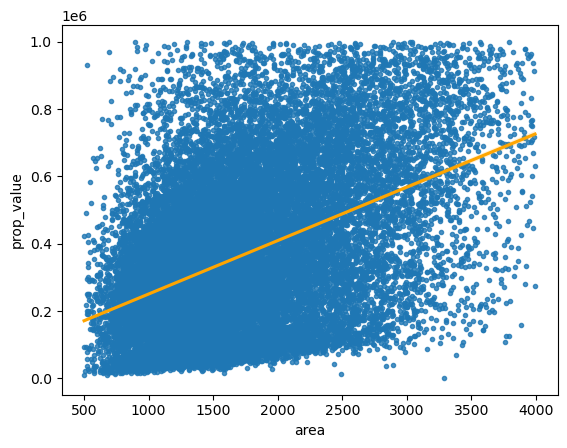

In [14]:
# explore area and property value
e.pear(train,'area','prop_value')
sns.regplot(data=train,x='area',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Spearman's R: age and prop_value
 r = -0.252384992941959, p = 0.0


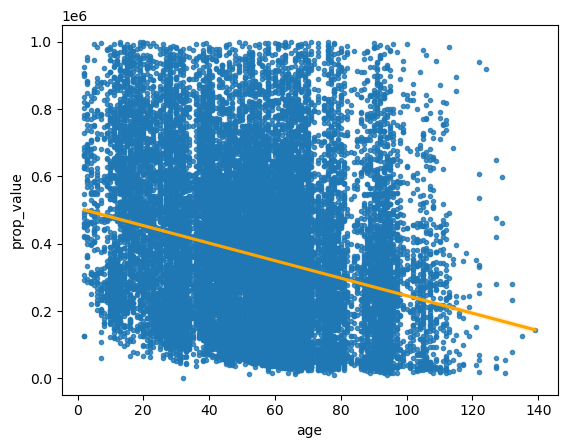

In [15]:
# explore age and property value
e.pear(train,'age','prop_value')
sns.regplot(data=train,x='age',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Spearman's R: roomcnt and prop_value
 r = 0.31423615228533996, p = 0.0


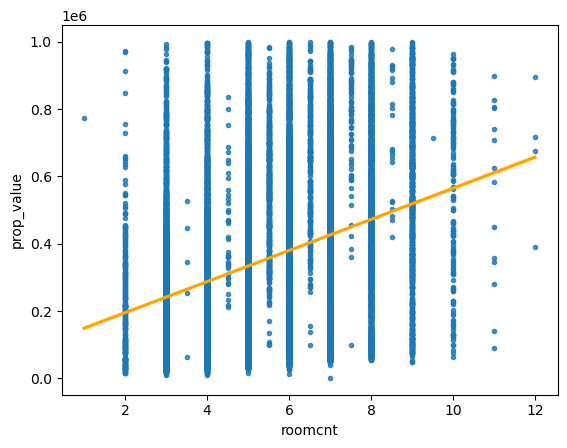

In [16]:
# explore room count and property value
e.pear(train,'roomcnt','prop_value')
sns.regplot(data=train,x='roomcnt',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Kruskal-Wallis H-Test:
 stat = 1214.0217620955239, p = 2.390693527371397e-264


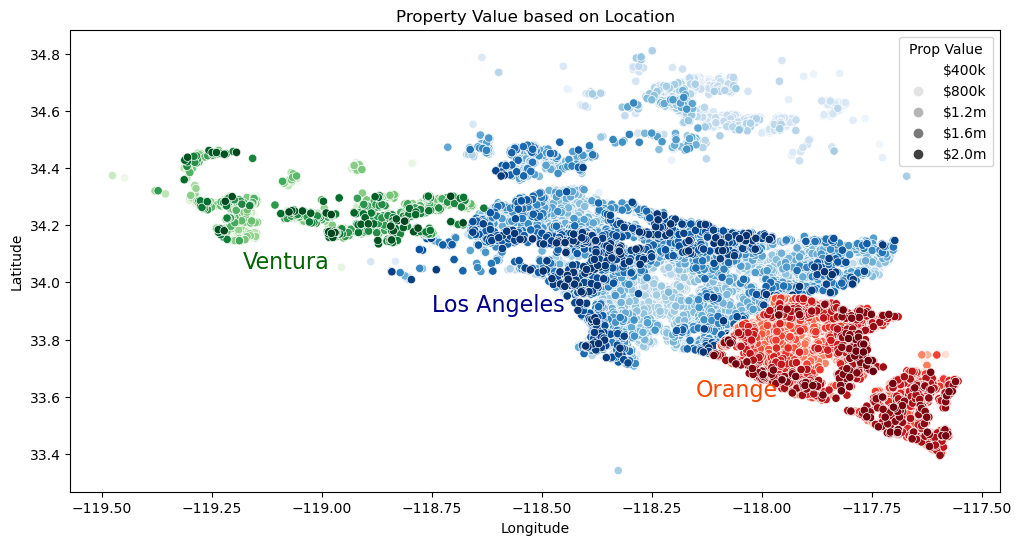

In [17]:
# explore average property value and counties
e.nova(train[train.county=='LA'].prop_value,train[train.county=='Orange'].prop_value,train[train.county=='Ventura'].prop_value)
e.plt_loc(train)

In [40]:
X_train,X_val,X_test = train.drop(columns=['prop_value','county','transactiondate']),val.drop(columns=['prop_value','county','transactiondate']),test.drop(columns=['prop_value','county','transactiondate'])
y_train,y_val,y_test = train[['prop_value']],val[['prop_value']],test[['prop_value']]

Xs_train,Xs_val,Xs_test = w.robs_zillow(X_train,X_val,X_test)

In [20]:
y_train.mean()[0]

362937.60430014116

In [21]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return round(rmse,2), round(r2,4)

In [47]:
def rfe_rev(Xs_train,y_train,r):
    lr = LinearRegression()
    rfe = RFE(lr,n_features_to_select=r)
    rfe.fit(Xs_train,y_train)
    rfe_ranks_df = pd.DataFrame({'Var':Xs_train.columns.to_list(),'Rank':rfe.ranking_})
    return rfe_ranks_df.sort_values('Rank')

df1 = None
# feat = ['baths_s','beds_s', 'area_s', 'roomcnt_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
feat = Xs_train.drop(columns=['heatingorsystemtypeid_s','threequarterbathnbr_s','stories_s','year_s','Orange_s','fullbathcnt_s','lotsizesquarefeet_s','garagetotalsqft_s','garagecarcnt_s']).columns
# feat = Xs_train.columns
for r in range(1,13):
    dfr = rfe_rev(Xs_train[feat],y_train,r)
    dfr = dfr.assign(n_features=r)
    df1 = pd.concat([df1,dfr]) if df1 is not None else dfr
df1.groupby(['Var']).Rank.mean().sort_values()

Var
area_s           1.000000
LA_s             1.083333
regionidzip_s    1.250000
pools_s          1.500000
roomcnt_s        1.833333
age_s            2.250000
latitude_s       2.750000
longitude_s      3.333333
garage_s         4.000000
has_ac_s         4.750000
baths_s          5.583333
beds_s           6.500000
Ventura_s        7.500000
Name: Rank, dtype: float64

In [22]:
def reg_mods(Xtr,ytr,Xv,yv,features=None,alpha=1,degree=2):
    '''
    Input X_train,y_train,X_val,y_val, list of features, alpha, and degree
    so that function will run through linear regression, lasso lars, and
    polynomial feature regression
    - diff feature combos
    - diff hyper params
    - output as df
    '''
    if features is None:
        features = Xtr.columns.to_list()
    # baseline as mean
    pred_mean = ytr.mean()[0]
    ytr_p = ytr.assign(pred_mean=pred_mean)
    yv_p = yv.assign(pred_mean=pred_mean)
    rmse_tr = mean_squared_error(ytr,ytr_p.pred_mean)**.5
    rmse_v = mean_squared_error(yv,yv_p.pred_mean)**.5
    r2_tr = r2_score(ytr, ytr_p.pred_mean)
    r2_v = r2_score(yv, yv_p.pred_mean)
    output = {
            'model':'bl_mean',
            'features':'None',
            'params':'None',
            'rmse_tr':rmse_tr,
            'rmse_v':rmse_v,
            'r2_tr':r2_tr,
            'r2_v':r2_v
        }
    metrics = [output]
    # create iterable for feature combos
    for r in range(1,(len(features)+1)):
        # cycle through feature combos for linear reg
        for feature in itertools.combinations(features,r):
            f = list(feature)
            # linear regression
            lr = LinearRegression()
            lr.fit(Xtr[f],ytr)
            # metrics
            pred_lr_tr = lr.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lr_tr)
            pred_lr_v = lr.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_lr_v)
            # table-ize
            output ={
                    'model':'LinearRegression',
                    'features':f,
                    'params':'None',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and alphas for lasso lars
        for feature,a in itertools.product(itertools.combinations(features,r),alpha):
            f = list(feature)
            # lasso lars
            ll = LassoLars(alpha=a,normalize=False,random_state=42)
            ll.fit(Xtr[f],ytr)
            # metrics
            pred_ll_tr = ll.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_ll_tr)
            pred_ll_v = ll.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_ll_v)
            # table-ize
            output ={
                    'model':'LassoLars',
                    'features':f,
                    'params':f'alpha={a}',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and degrees for polynomial feature reg
        for feature,d in itertools.product(itertools.combinations(features,r),degree):
            f = list(feature)
            # polynomial feature regression
            pf = PolynomialFeatures(degree=d)
            Xtr_pf = pf.fit_transform(Xtr[f])
            Xv_pf = pf.transform(Xv[f])
            lp = LinearRegression()
            lp.fit(Xtr_pf,ytr)
            # metrics
            pred_lp_tr = lp.predict(Xtr_pf)
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lp_tr)
            pred_lp_v = lp.predict(Xv_pf)
            rmse_v,r2_v = metrics_reg(yv,pred_lp_v)
            # table-ize
            output ={
                    'model':'PolynomialFeature',
                    'features':f,
                    'params':f'degree={d}',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
    return pd.DataFrame(metrics)

In [ ]:
metrics = reg_mods(Xs_train,y_train,Xs_val,y_val,degree=[2,3,4],features=feat)
metrics

In [29]:
# poly best f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s'], degree=4
# lin reg f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
# lasso f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s'], alpha=1
# ['baths_s','beds_s', 'area_s', 'roomcnt_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']

In [30]:
def final_model(model,X_train,y_train,X_val,y_val):
    if model == 'lr':
        # features
        f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # model
        lr = LinearRegression()
        lr.fit(X_train[f],y_train)
        # metrics
        pred_lr_tr = lr.predict(X_train[f])
        rmse_tr,r2_tr = metrics_reg(y_train,pred_lr_tr)
        pred_lr_v = lr.predict(X_val[f])
        rmse_v,r2_v = metrics_reg(y_val,pred_lr_v)
        print('Linear Regression')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    elif model == 'poly':
        # features
        f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # polynomial feature regression
        pf = PolynomialFeatures(degree=4)
        X_train_pf = pf.fit_transform(X_train[f])
        X_val_pf = pf.transform(X_val[f])
        # model
        pr = LinearRegression()
        pr.fit(X_train_pf,y_train)
        # metrics
        pred_pr_tr = pr.predict(X_train_pf)
        rmse_tr,r2_tr = metrics_reg(y_train,pred_pr_tr)
        pred_pr_v = pr.predict(X_val_pf)
        rmse_v,r2_v = metrics_reg(y_val,pred_pr_v)
        print('Polynomial Features through Linear Regression')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    elif model == 'lasso':
        # features
        f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # model
        ll = LassoLars(alpha=1,normalize=False)
        ll.fit(X_train[f],y_train)
        # metrics
        pred_ll_tr = ll.predict(X_train[f])
        rmse_tr,r2_tr = metrics_reg(y_train,pred_ll_tr)
        pred_ll_v = ll.predict(X_val[f])
        rmse_v,r2_v = metrics_reg(y_val,pred_ll_v)
        print('Lasso Lars')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    else:
        print('Please include model argument: lr, poly, lasso')

In [31]:
final_model('lr',Xs_train,y_train,Xs_val,y_val)

Linear Regression
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.5    R2: 0.397


In [32]:
final_model('poly',Xs_train,y_train,Xs_val,y_val)

Polynomial Features through Linear Regression
Train       RMSE: 266137.07   R2: 0.4996
Validate    RMSE: 274174.47    R2: 0.464


In [33]:
final_model('lasso',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.44    R2: 0.397


In [34]:
def test_model(X_train,y_train,X_test,y_test):
    # features
    f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
    # polynomial feature regression
    pf = PolynomialFeatures(degree=4)
    X_train_pf = pf.fit_transform(X_train[f])
    X_test_pf = pf.transform(X_test[f])
    # model
    pr = LinearRegression()
    pr.fit(X_train_pf,y_train)
    # metrics
    pred_pr_t = pr.predict(X_test_pf)
    rmse_t,r2_t = metrics_reg(y_test,pred_pr_t)
    print('Polynomial Features through Linear Regression')
    print(f'Test    RMSE: {rmse_t}    R2: {r2_t}')

In [35]:
test_model(Xs_train,y_train,Xs_test,y_test)

Polynomial Features through Linear Regression
Test    RMSE: 270756.91    R2: 0.4851


In [36]:
def plt_err(Xs_train,y_train,Xs_test,y_test):
    # features
    f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
    # polynomial feature regression
    pf = PolynomialFeatures(degree=4)
    X_train_pf = pf.fit_transform(Xs_train[f])
    X_test_pf = pf.transform(Xs_test[f])
    # model
    pr = LinearRegression()
    pr.fit(X_train_pf,y_train)
    # metrics
    pred_pr_t = pd.DataFrame(pr.predict(X_test_pf),index=y_test.index,columns=['y_pred'])
    pred_mean = y_test
    pred_mean = pred_mean.assign(baseline=pred_mean.prop_value.mean())
    plt.figure(figsize=(16,8))
    plt.plot(y_test, pred_mean.baseline, alpha=.5, color="black", label='_nolegend_')
    plt.annotate("Baseline: Predict Using Mean", (1800000, 350000))
    plt.plot(y_test, y_test, alpha=.5, color="blue", label='_nolegend_')
    plt.annotate("The Ideal Line: Predicted = Actual", (1800000, 1850000), rotation=24.5)
    plt.scatter(y_test, pred_pr_t, alpha=.2, color="green", s=100, label="Model 4th degree Polynomial")
    plt.legend()
    plt.xlabel("Actual Property Value ($ Millions)")
    plt.ylabel("Predicted Property Value ($ Millions)")
    plt.title("Where are predictions more extreme? More modest?")
    plt.show()

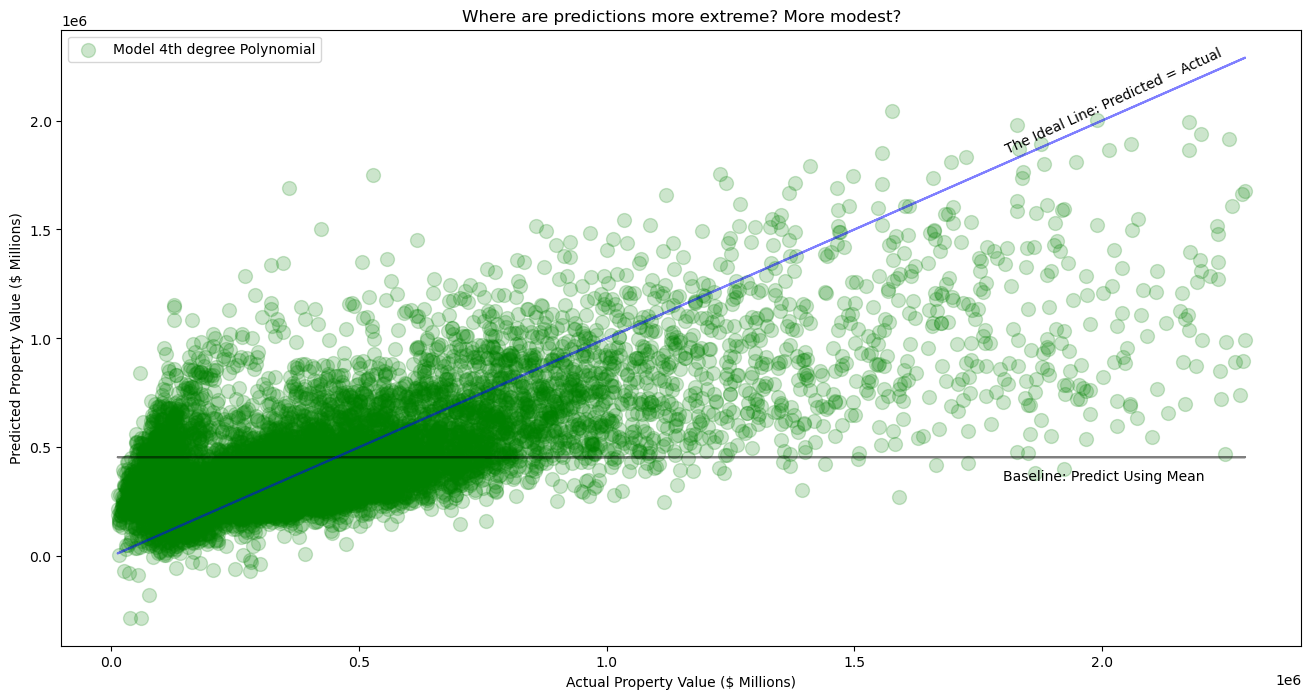

In [37]:
plt_err(Xs_train,y_train,Xs_test,y_test)